Here I am investigating called TRD regions for whether there is any known SV (based on Victor's VCF) that is different between the parental strains in that region.

# Todo
- joint plot victor VCF with AF
- some sort of output that says hey there is XYZ in the TRD region
- pixy PDF production
- implement iteration over all

In [1]:
library(tidytable)
library(tidyverse)
library(naturalsort)
library(ggplot2)
library(RColorBrewer)
source("~/BrusselSprouts/scripts/functions.R")


Attaching package: 'tidytable'


The following objects are masked from 'package:stats':

    dt, filter, lag


The following object is masked from 'package:base':

    %in%


-- Attaching packages ----------------------------------------------------------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.1
v tibble  3.1.8     v dplyr   1.1.0
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.3     v forcats 1.0.0
-- Conflicts -------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::across()                masks tidytable::across()
x dplyr::add_count()             masks tidytable::add_count()
x dplyr::add_tally()             masks tidytable::add_tally()
x dplyr::anti_join()             masks tidytable::anti_join()
x dplyr::arrange()               masks tidytable::arrange()
x dplyr::between()               masks tidytable::between()
x dplyr::bind_cols()             masks tidytable::bin

In [2]:
output_dir<-"/home/jnrunge/data/trd/SV_analysis"

In [3]:
# per trd region, I need focal IDs (numeric in the computed data) and chr,from,to.
# then I calculate the values for that region and compare them to the random regions

# load crosses
crosses_xlsx=readxl::read_xlsx("~/data/trd/Crosses.xlsx", sheet=2)
cc=data.frame("Cross ID"=c(paste0("ChrisC",1:8)),
                                  "Short name 1"=c("ACP","BAP","CCD","ATE","ACK","AKE","BAH","ANG"),
                                  "Short name 2"=c("BFP","CMP","CPG","SACE_YCR","ACV","BAH","CGD","CEI"), stringsAsFactors=FALSE)
colnames(cc)=str_replace_all(colnames(cc), fixed("."), " ")
crosses_xlsx <- bind_rows(crosses_xlsx[,c("Cross ID","Short name 1","Short name 2")],
                        cc)


# load all TRD regions
TRD_regions<-fread_and_bind_files(list.files("/home/jnrunge/data/TRD/results/shiny/",pattern="TRD_regions.csv.gz$",full.names = TRUE))
TRD_regions<-mutate(TRD_regions, file=basename(file))%>%separate(file, c("cross","discard"), "-")%>%select(-discard)%>%filter(chr_start==chr_end)%>%
rename(chr=chr_start)%>%select(-chr_end)

# translate global positions to chr positions

for(c in select(TRD_regions,cross)%>%distinct()%>%pull())
    {
    AF<-fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))
    
    tmp_TRD_regions<-filter(TRD_regions, cross==c)%>%select(-any_of("start"))%>%
              left_join(select(AF, chr,pos,global_pos)%>%
              rename(global_start=global_pos), by=c("chr","global_start"))%>%rename(start=pos)
    
    TRD_regions<-filter(TRD_regions, cross!=c)%>%bind_rows(tmp_TRD_regions)
}

TRD_regions<-mutate(TRD_regions, end=global_end-(global_start-start))

head(TRD_regions)

New names:
* `Is in Stock` -> `Is in Stock...4`
* `Is in Stock` -> `Is in Stock...6`


,ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end
,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>
1,1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339
2,9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684
3,13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958
4,14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299
5,4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414
6,11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250


In [4]:
# pre-calculate some genome comparisons
initial_timedate=Sys.time()
scripts_dir<-"/home/jnrunge/data/trd/scripts"

for(i in 1:nrow(crosses_xlsx)){
    crosses_xlsx_slice<-slice(crosses_xlsx, i)
    cross<-pull(crosses_xlsx_slice, `Cross ID`)
    parent1<-pull(crosses_xlsx_slice,`Short name 1`)
    parent2<-pull(crosses_xlsx_slice,`Short name 2`)
    fasta_parent1<-paste0("/home/vloegler/SVCalling2/03-data/BestCollapsed/",parent1,".Final.fasta")
    fasta_parent2<-paste0("/home/vloegler/SVCalling2/03-data/BestCollapsed/",parent2,".Final.fasta")

    mashmap_possible<-TRUE
    if(sum(!file.exists(c(fasta_parent1,fasta_parent2)))>0){
        mashmap_possible<-FALSE
    }
    cmd1<-""
    if(mashmap_possible & !file.exists(mash_file<-paste0("/home/jnrunge/data/trd/Victor_SV/dotplots/",parent1,"_",parent2,".out"))){
        cmd1<-paste0("cd /home/jnrunge/data/trd/Victor_SV/dotplots && mashmap -r ",fasta_parent1," -q ",fasta_parent2," -o ",parent1,"_",parent2,".out -s 500")

    }

    if(mashmap_possible){
        syri_file<-paste0("/home/jnrunge/data/trd/Victor_SV/alignments/",parent1,"_",parent2,".mi80l100syri.out.gz")
        
        cmd2<-paste0("sh -xe ~/TRD/03_GenomicSignals/02_VCF_SV_syri.sh ", parent1, " ", parent2)
    if(file.exists(syri_file)){
            cmd2<-""
        }
        sbatch_list=execute_complex_sbatch(c(cmd1,cmd2), jobname = "mashmap_syri", scripts_dir = scripts_dir, uniqueRunID = cross, cores="1", mem="80gb", time="short", env="minimash", initial_timedate = initial_timedate, jobs_simul = 10, jobs_total = 30)

    }


    }

if(exists("sbatch_list")){
    start_sbatch_list(sbatch_list, 5, "mashmap_syri", initial_timedate)
    }

[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC1.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC2.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC3.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC4.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC5.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC6.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC7.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC8.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC9.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC10.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC11.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC12.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC13.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC14.sbatch"
[1] "/home/jnrunge/data/trd/scripts/mashmap_syri-YJNRC15.sbatch"
[1] "/home/jnrunge/data/trd/script

In [5]:
SVs<-fread(cmd="zcat /home/jnrunge/data/trd/Victor_SV/SV.730Samples.vcf.gz | grep -v ^## | cut -f 4,5 --complement")
SVs<-separate(SVs, ID,c("TYPE","chr","pos","len","LEN"), "_")%>%select(-chr, -pos, -len)

Joining with `by = join_by(V1)`
Joining with `by = join_by(V6)`
Warning message:
"There were 4 warnings in `mutate()`.
The first warning was:
i In argument: `V2 = as.numeric(V2)`.
Caused by warning:
! NAs introduced by coercion
i Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings."
Joining with `by = join_by(V1)`
Joining with `by = join_by(V6)`
Warning message:
"There were 4 warnings in `mutate()`.
The first warning was:
i In argument: `V2 = as.numeric(V2)`.
Caused by warning:
! NAs introduced by coercion
i Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings."


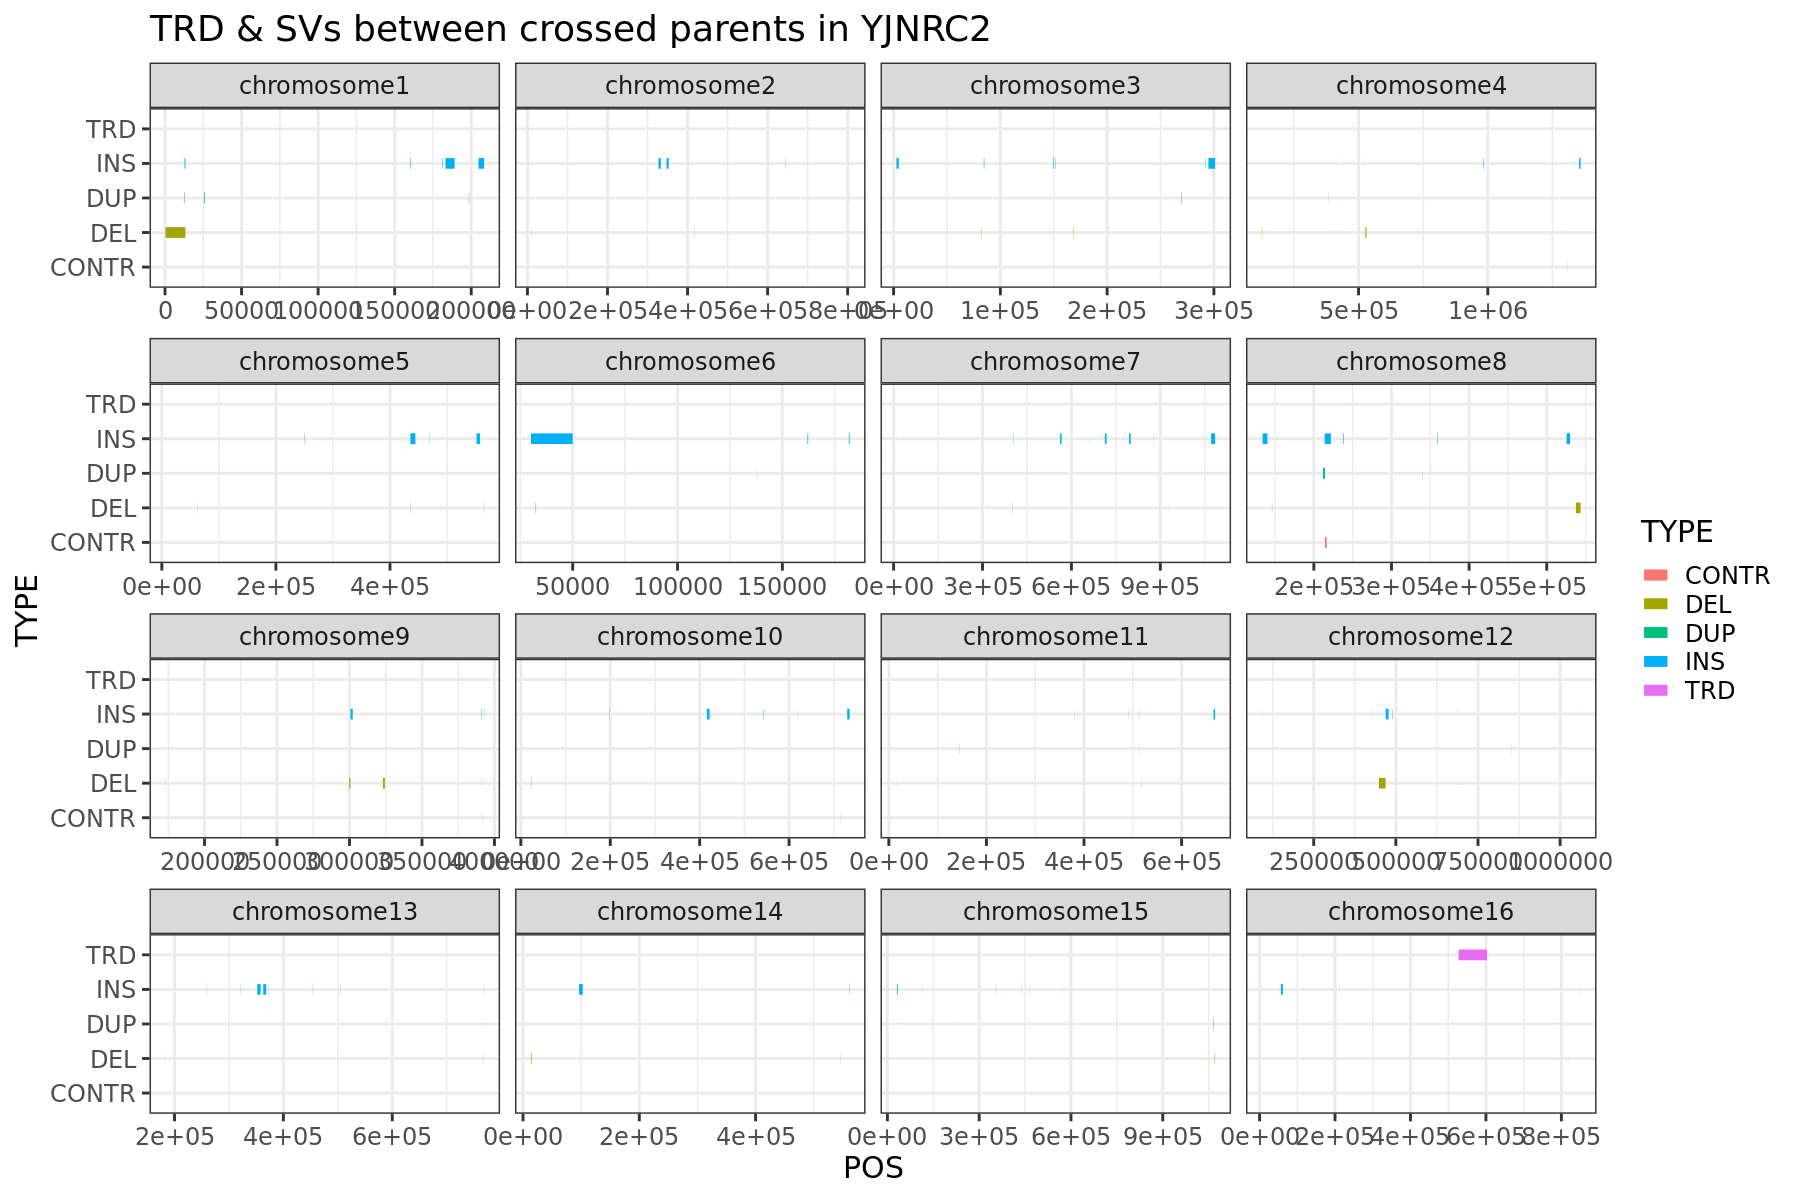

Joining with `by = join_by(V1)`
Joining with `by = join_by(V6)`


ERROR: Error in fread(syri_file, header = FALSE): File '/home/jnrunge/data/trd/Victor_SV/alignments/ABS_BEF.mi80l100syri.out.gz' does not exist or is non-readable. getwd()=='/home/jnrunge/TRD/03_GenomicSignals'


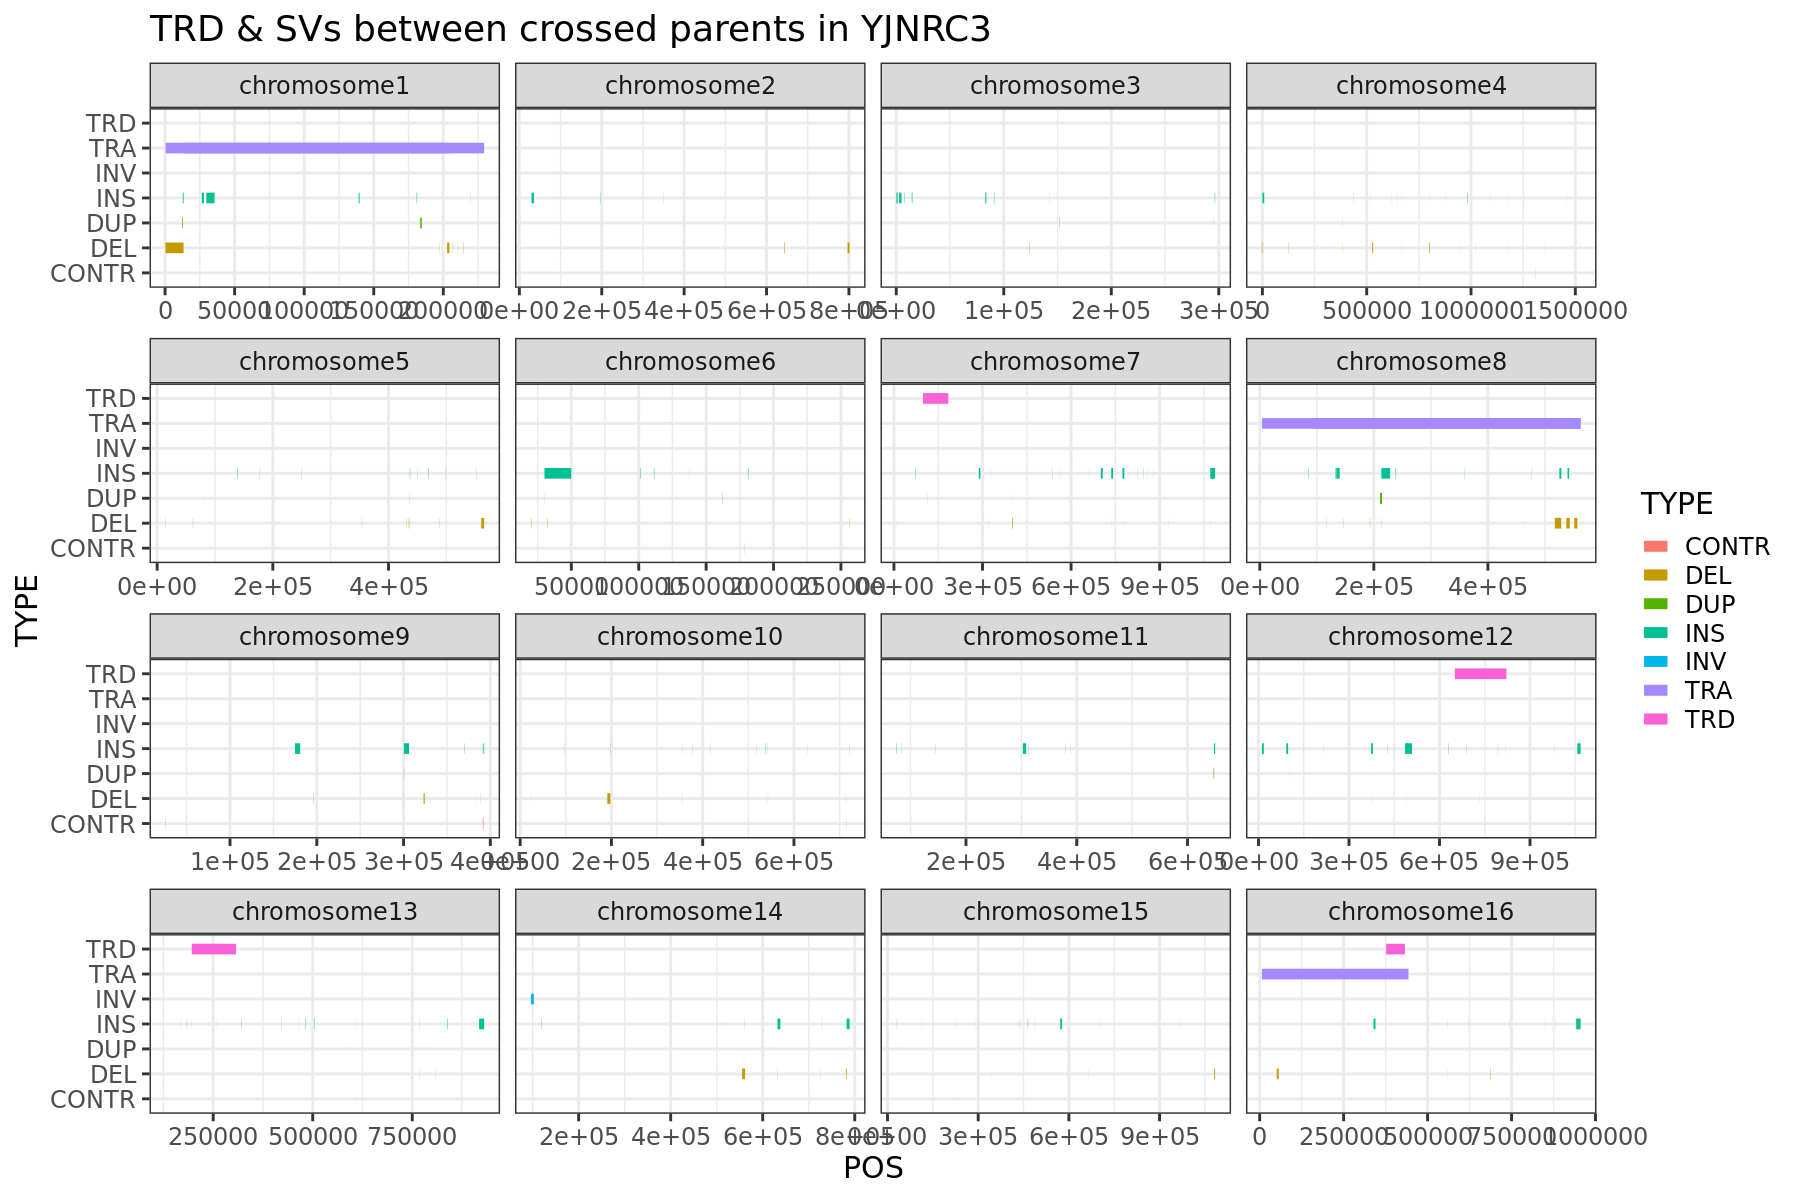

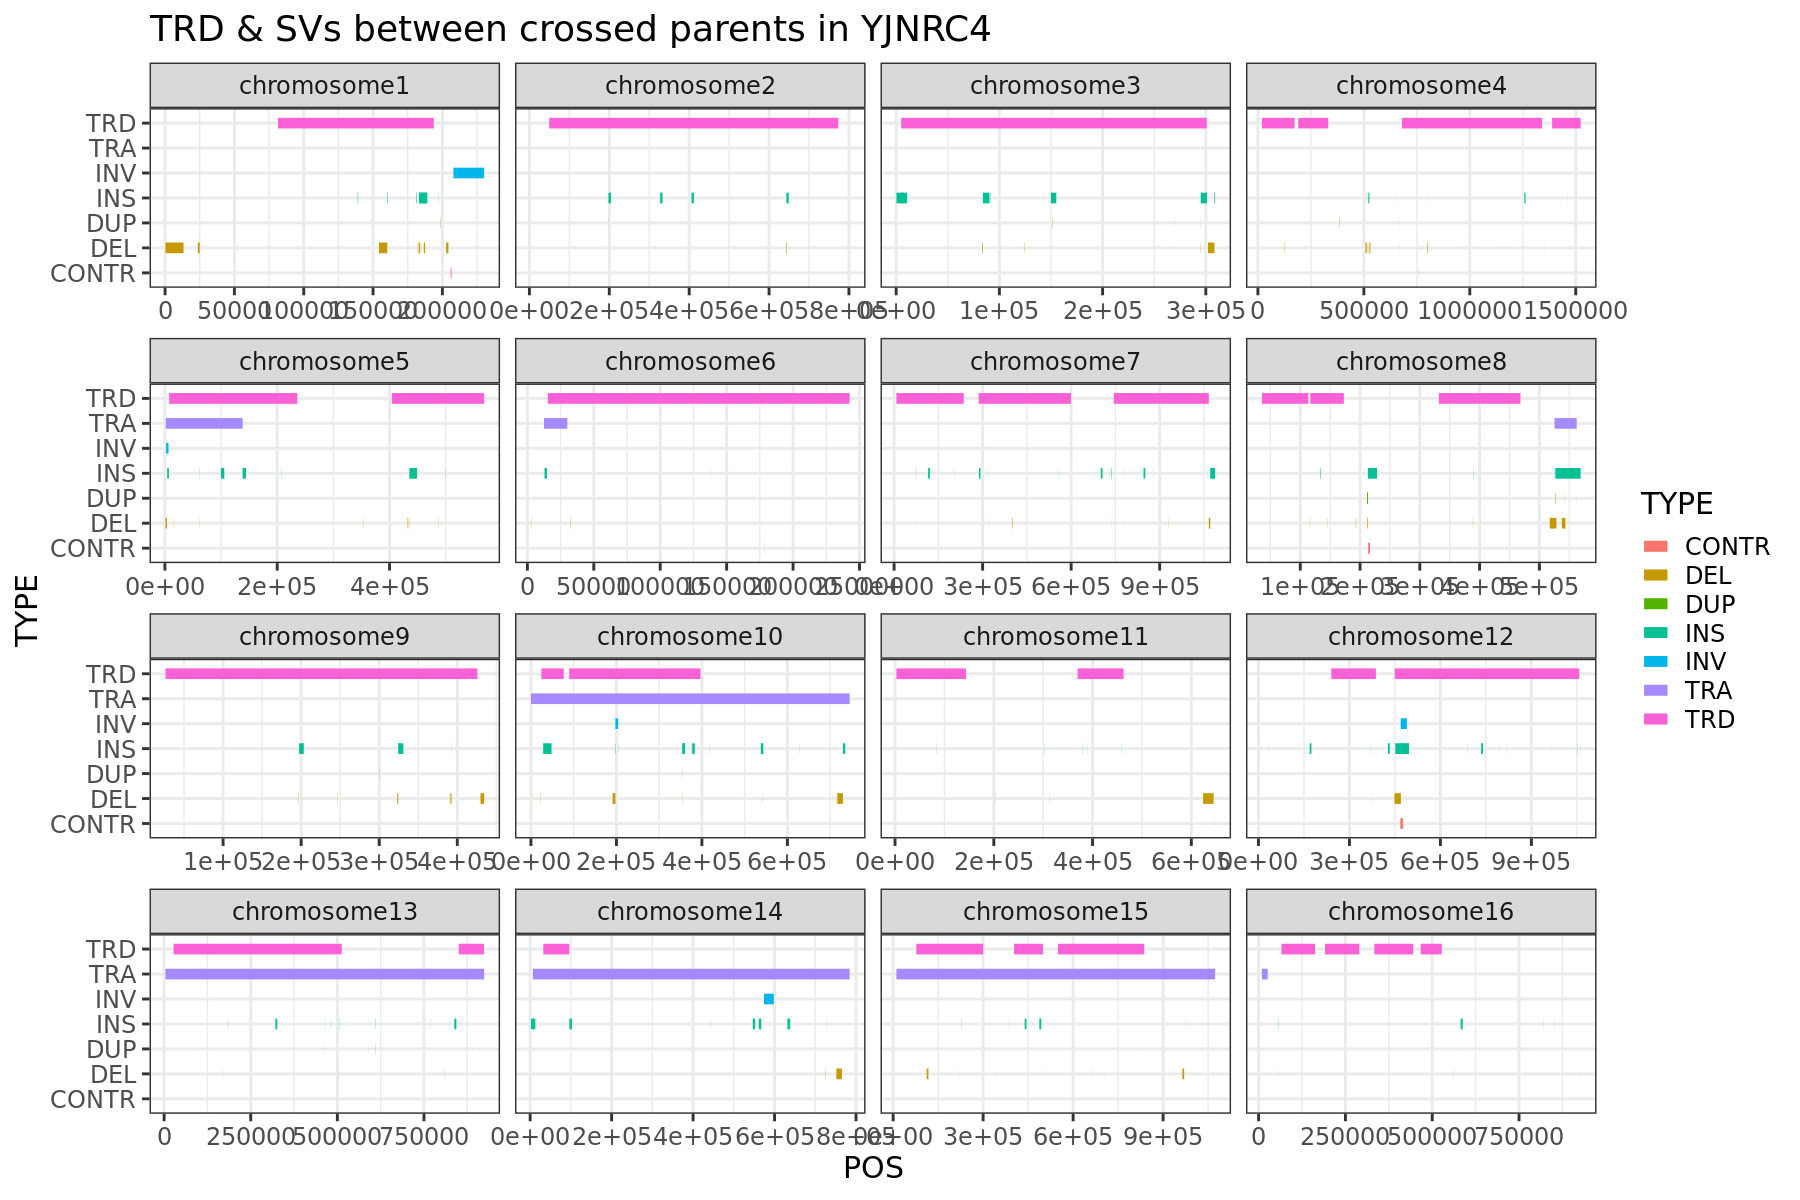

In [100]:
for(i in 1:nrow(crosses_xlsx)){
    crosses_xlsx_slice<-slice(crosses_xlsx, i)
    cross<-pull(crosses_xlsx_slice, `Cross ID`)
    cross_value <- cross
    TRD_regions_cross <- filter(TRD_regions, cross == cross_value)
    TRD_regions_cross
    if(nrow(TRD_regions_cross)==0){
        next
    }

    parent1<-pull(crosses_xlsx_slice,`Short name 1`)
    parent2<-pull(crosses_xlsx_slice,`Short name 2`)

    if(!(parent1 %in% colnames(SVs) & parent2 %in% colnames(SVs))){
        print("Parent(s) not in VCF")
        print(paste0("Maybe these fit? ", which(grepl(parent1,colnames(SVs))),
                    " ", which(grepl(parent2,colnames(SVs)))))
        next
    }

    SVs_cross<-select(SVs, 1:4, TYPE, LEN, FORMAT, which(colnames(SVs)%in%(c(parent1,parent2))), INFO)%>%
                filter(substr(.data[[parent1]],1,1) != substr(.data[[parent2]],1,1) | 
                      substr(.data[[parent1]],1,1) != substr(.data[[parent2]],3,3))%>%
                mutate(LEN=as.numeric(LEN))

    SVs_cross<-SVs_cross%>%mutate(`#CHROM` = fct_relevel(`#CHROM`, naturalsort(unique(pull(SVs_cross,`#CHROM`)))))
    TRD_regions_cross<-TRD_regions_cross%>%mutate(chr = fct_relevel(chr, naturalsort(unique(pull(TRD_regions_cross,chr)))))

    sv_victor_overview<-ggplot(SVs_cross, aes(x=POS, xend=POS+LEN, y=TYPE, yend=TYPE, color=TYPE))+
    geom_segment(linewidth=3)+facet_wrap(~`#CHROM`,scales="free_x")+theme_bw(18)+ggtitle(paste0("TRD & SVs between crossed parents in ",cross))+
    geom_segment(linewidth=3,data=TRD_regions_cross%>%rename(`#CHROM`=chr)%>%mutate(TYPE="TRD"), mapping=aes(x=start, xend=end, y=TYPE, yend=TYPE, color=TYPE))
    saveRDS(sv_victor_overview, paste0(output_dir,"/",cross,".",
                         "sv_victor",".RDS"))
    print(sv_victor_overview)

    TRD_regions_cross

    Victor_SV_TRD_overlap<-data.table()

    # iterate over TRD_regions_cross to detect SVs overlapping
    for(which_trd in 1:nrow(TRD_regions_cross)){
        trd_region_slice<-slice(TRD_regions_cross, which_trd)
        SVs_cross_this_region<-filter(SVs_cross, as.character(`#CHROM`) == as.character(pull(trd_region_slice, chr)),

              (POS >= pull(trd_region_slice, start) & POS <= pull(trd_region_slice, end)) 
                                      | 
                                      (((POS+abs(LEN)) >= pull(trd_region_slice, start)) & ((POS+abs(LEN)) <= pull(trd_region_slice, end)))
                                   | 
                                      (((POS) < pull(trd_region_slice, start)) & ((POS+abs(LEN)) > pull(trd_region_slice, end)))  
                                     )
        Victor_SV_TRD_overlap<-bind_rows(Victor_SV_TRD_overlap,select(SVs_cross_this_region, TYPE, LEN)%>%mutate(LEN_rel=LEN/pull(trd_region_slice,lengthBp),
                                                          ID=pull(trd_region_slice,ID)))
    }

    Victor_SV_TRD_overlap<-mutate(Victor_SV_TRD_overlap, source="VictorSV")


    TRD_regions_cross_SV_data<-left_join(TRD_regions_cross, Victor_SV_TRD_overlap, by="ID", multiple="all")%>%select(cross,ID,TYPE,LEN,LEN_rel,source)

    if(!file.exists(mash_file<-paste0("/home/jnrunge/data/trd/Victor_SV/dotplots/",parent1,"_",parent2,".out"))){
        next
    }

    mash<-fread(mash_file, header=FALSE)

    # we need to convert to global positions (chr ordered)
    # going to be prone to issues if assembly is not great
    # will just use naturalsorted chr names to determine order

    get_global_pos<-function(df, chr_column, start_column, end_column, which_1_or_2){
        chrs_sizes<-select(df, all_of(c(chr_column, chr_column+1)))%>%distinct()
        chrs_sizes <- chrs_sizes[naturalorder(chrs_sizes%>%select(1)%>%pull()), ]
        colnames(chrs_sizes)[2]<-"V2"
        chrs_sizes <- mutate(chrs_sizes, previous_bp = c(0, cumsum(V2[-length(V2)])))
        colnames(chrs_sizes)[3]<-paste(colnames(chrs_sizes)[3],chr_column,sep="_")
        df<-left_join(df, chrs_sizes%>%select(1,3))

        df <- df %>%
                mutate(!!paste0("global_pos_start_", which_1_or_2) := 
               .data[[colnames(df)[start_column]]] +
               .data[[colnames(chrs_sizes)[3]]])

        df <- df %>%
                mutate(!!paste0("global_pos_end_", which_1_or_2) := 
               .data[[colnames(df)[end_column]]] +
               .data[[colnames(chrs_sizes)[3]]])


        return(df)
    }
    mash<-mutate(mash, global_pos_start_1=NA, global_pos_end_1=NA,
                global_pos_start_2=NA, global_pos_end_2=NA)
    mash<-get_global_pos(mash, 1, 3, 4, 1)
    mash<-get_global_pos(mash, 6, 8, 9, 2)
    mash<-mash%>%mutate(V6 = fct_relevel(V6, naturalsort(unique(pull(mash,V6)))))
    mash<-mash%>%mutate(V1 = fct_relevel(V1, naturalsort(unique(pull(mash,V1)))))

    num_colors <- max(c(length(unique(pull(mash,V6))),length(unique(pull(mash,V1)))))
    my_palette <- colorRampPalette(brewer.pal(8, "Set3"))(num_colors)

    mash_1_plot<-ggplot(mash, aes(x=global_pos_start_1, xend=global_pos_end_1,
                     y=global_pos_start_2, yend=global_pos_end_2, color=V6)) +
      geom_segment(linewidth=2) +theme_bw(18)+scale_color_manual(values = my_palette)+
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

    mash_2_plot<-ggplot(mash, aes(x=global_pos_start_2, xend=global_pos_end_2,
                     y=global_pos_start_1, yend=global_pos_end_1, color=V1)) +
      geom_segment(linewidth=2) +theme_bw(18)+scale_color_manual(values = my_palette)+
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


    mash_1_plot
    mash_2_plot

    saveRDS(mash_1_plot, paste0(output_dir,"/",cross,".",
                         "mash1",".RDS"))
    saveRDS(mash_2_plot, paste0(output_dir,"/",cross,".",
                         "mash2",".RDS"))

    syri_file<-paste0("/home/jnrunge/data/trd/Victor_SV/alignments/",parent1,"_",parent2,".mi80l100syri.out.gz")

    syri<-fread(syri_file, header=FALSE)
    syri<-mutate(syri, V2=as.numeric(V2), V3=as.numeric(V3),
                V7=as.numeric(V7), V8=as.numeric(V8))
    head(syri)

    Syri_SV_TRD_overlap<-data.table()

    # iterate over TRD_regions_cross to detect SVs overlapping
    for(which_trd in 1:nrow(TRD_regions_cross)){
        trd_region_slice<-slice(TRD_regions_cross, which_trd)
        SVs_cross_this_region<-filter(syri, V11%in%c('DUP','INVDP','DEL','INS','CPL','HDR','CPG','TRANS','INVTR','TDM','INV'),
                                      (endsWith(V1, as.character(pull(trd_region_slice, chr))) &

              (V2 >= pull(trd_region_slice, start) & V2 <= pull(trd_region_slice, end)) 
                                      | 
                                      (((V3) >= pull(trd_region_slice, start)) & ((V3) <= pull(trd_region_slice, end)))
                                   | 
                                      (((V2) < pull(trd_region_slice, start)) & ((V3) > pull(trd_region_slice, end)))) | 

                                      (endsWith(V6, as.character(pull(trd_region_slice, chr))) &

              (V7 >= pull(trd_region_slice, start) & V7 <= pull(trd_region_slice, end)) 
                                      | 
                                      (((V8) >= pull(trd_region_slice, start)) & ((V8) <= pull(trd_region_slice, end)))
                                   | 
                                      (((V7) < pull(trd_region_slice, start)) & ((V8) > pull(trd_region_slice, end))))
                                     )

        SVs_cross_this_region<-rename(SVs_cross_this_region, TYPE=V11)%>%
        mutate(LEN=ifelse((V3-V2)>(V8-V7), # because one INS would be 0, one the actual size
                          V3-V2, V8-V7))
        Syri_SV_TRD_overlap<-bind_rows(Syri_SV_TRD_overlap,select(SVs_cross_this_region, TYPE, LEN)%>%mutate(LEN_rel=LEN/pull(trd_region_slice,lengthBp),
                                                          ID=pull(trd_region_slice,ID)))
    }

    Syri_SV_TRD_overlap<-mutate(Syri_SV_TRD_overlap, source="Syri")



    TRD_regions_cross_SV_data<-bind_rows(TRD_regions_cross_SV_data,left_join(TRD_regions_cross, Syri_SV_TRD_overlap, by="ID", multiple="all")%>%select(cross,ID,TYPE,LEN,LEN_rel,source))

    head(TRD_regions_cross_SV_data)
    saveRDS(TRD_regions_cross_SV_data, paste0(output_dir,"/",cross,".",
                         "SV_data",".RDS"))

    library(ggplot2)
    options(repr.plot.width=15, repr.plot.height=10)

    syri<-syri%>%mutate(V1 = fct_relevel(V1, naturalsort(unique(pull(syri,V1)))))

    syri<-syri%>%mutate(V6 = fct_relevel(V6, naturalsort(unique(pull(syri,V6)))))

    p<-ggplot(syri%>%filter(V1!="-",
                        V11%in%c('DUP','INVDP','DEL','INS','CPL','HDR','CPG','TRANS','INVTR','TDM','INV')), aes(x=V2, xend=V3+50, y=V11, yend=V11, color=V11))+
    geom_segment(linewidth=2)+facet_wrap(~V1, scales="free_x")+theme_bw(18)+
    ggtitle(paste0("Syri-based SVs between crossed parents in ",cross))

    saveRDS(p, paste0(output_dir,"/",cross,".",
                         "syri_1",".RDS"))

    p<-ggplot(syri%>%filter(V6!="-",
                        V11%in%c('DUP','INVDP','DEL','INS','CPL','HDR','CPG','TRANS','INVTR','TDM','INV')), aes(x=V7, xend=V8+50, y=V11, yend=V11, color=V11))+
    geom_segment(linewidth=2)+facet_wrap(~V6, scales="free_x")+theme_bw(18)+
    ggtitle(paste0("Syri-based SVs between crossed parents in ",cross))

    saveRDS(p, paste0(output_dir,"/",cross,".",
                         "syri_2",".RDS"))
    }